# Домашнее задание 2. StarGAN

### Загрузка данных
В данном задании вам предстоит работать с CelebA 64x64 и генерировать новые лица с заданными аттрибутами

In [1]:
import requests
url = 'https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/utils/datasets/celeba.py'
open('celeba.py', 'wb').write(requests.get(url).content);
url = 'https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/data/celeba/list_attr_celeba.txt'
open('list_attr_celeba.txt', 'wb').write(requests.get(url).content);


In [2]:
!pip install natsort

In [3]:
from celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm

from torch import Tensor

Загрузим человекочитаемые названия доменов

In [4]:
with open('list_attr_celeba.txt', 'r') as f:
    attr_name = np.array(f.readline().split(' ')[:-1])
attr_name

array(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype='<U19')

In [6]:
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

Мы будем использовать урезанный датасет (`crop=True`) для быстрой загрузки на диск.

Для обучения модели вам нужно будет загрузить полную версию датасета.

Перед отправкой тетрадки в автопроверку ***ПРОВЕРЬТЕ*** что `crop=True`, иначе ваше решение будет таймаутиться

Главная проблема мультидоменной генерации на селебе - наличие большого количества "бесполезных" классов, например 'Arched_Eyebrows', 'Attractive' 'Bags_Under_Eyes итд. Чтобы сделать задачу чуть проще, в этой домашке мы предлагаем вам взять 10 аттрибутов и учить im2im только на них

In [7]:
from random import randint

class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        indices = [8, 9, 11, 15, 16, 20, 22, 28, 35, 39]
        image, target = super().__getitem__(idx)
        target = target['attributes'] == 1
        new_target = target[indices]
        if sum(new_target) == 0:
            return self.__getitem__(randint(0, len(self)))
        return image, new_target


In [8]:
attr_name = attr_name[[8, 9, 11, 15, 16, 20, 22, 28, 35, 39]]

In [9]:
dataset = CelebaCustomDataset(
    transform=transform,
    attr_file_path='list_attr_celeba.txt',
    crop=True
)
img, attr = dataset[0]
img.shape

torch.Size([3, 64, 64])

In [10]:
attr

tensor([False, False,  True, False, False, False, False, False, False,  True])

### Визуализация датасета

In [11]:
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis('off')

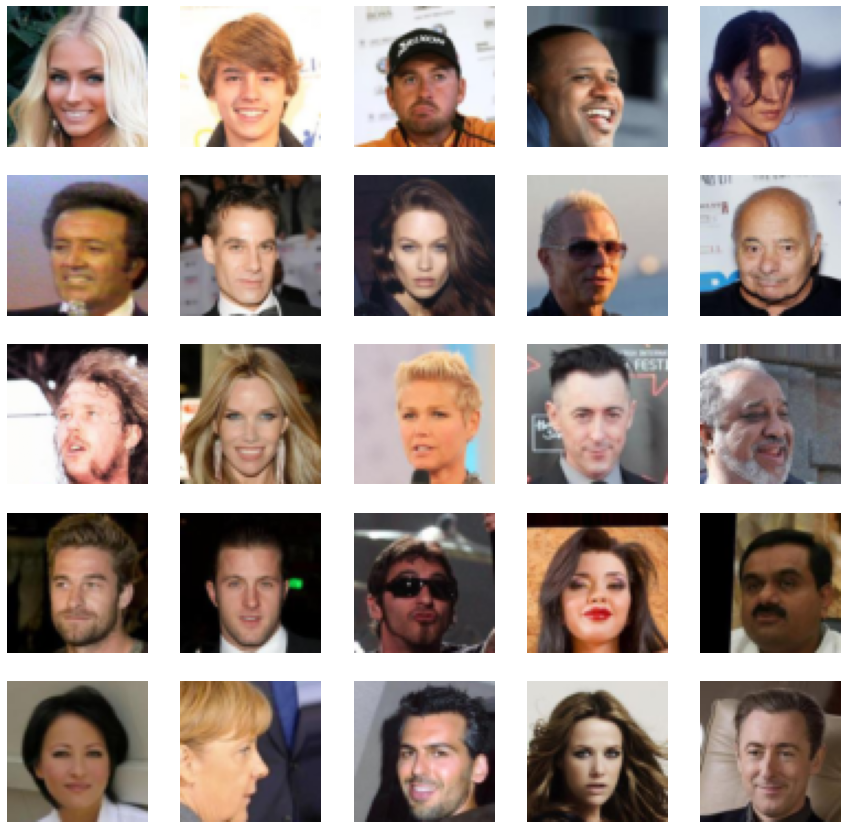

In [12]:
plt.figure(figsize=(15, 15))

for i in range(25):
    img, attr = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

### Задача 1 (3/10 балла). Обучите low-res StarGanV1 на ограниченном подмножестве аттрибутов



В рамках данного задания предлагается реализовать и обучить [StarGAN v1](https://arxiv.org/pdf/1711.09020.pdf) для генерации лиц с заданными аттрибутами

<img src='https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/images/stargan_v1.png' width=600>

Вы можете добавлять любые дополнительные  параметры и использовать любые трюки для стабилизации/улучшения обучения на свое усмотрение. -->


In [13]:
class ResidualBlock(nn.Module):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.x = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(256),
        )
    def forward(self, x):
        return x + self.x(x)

In [14]:
class Generator(nn.Module):
    def __init__(self, hidden_dim=32):
        """
        you can use any parameters here, for example ->
        hidden_dim: number of channels used in convs 
        """
        super().__init__()
        self.down = nn.Sequential(
            nn.Conv2d(13, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True))
        
        self.bottleneck = nn.Sequential(*[ResidualBlock() for _ in range(6)])
        self.up = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
        
    def forward(self, x: Tensor, y: Tensor):
        """
        x: original image 
        y: target domain
        """
        y = y.view(y.size(0), y.size(1), 1, 1)
        y = y.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, y], dim=1)
        x = self.down(x)
        x = self.bottleneck(x)
        x = self.up(x)
        return x
        

In [15]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.x = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU())
            
        self.pic = nn.Sequential(
            nn.Conv2d(2048, 1, kernel_size=3, stride=1, padding=1))
        self.domain = nn.Sequential(
            nn.Conv2d(2048, 10, kernel_size=1, stride=1, padding=0))
        

    def forward(self, x: Tensor):
        x = self.x(x)
        pic = self.pic(x)
        domain = self.domain(x)
        return pic, domain.view(domain.size(0), domain.size(1))

Дальше идут несколько вспомогательных клеточек которые вы можете использовать, а можете не использовать

In [16]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, drop_last=True)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

gen = Generator().to(device)
disc = Discriminator().to(device)

g_optim = torch.optim.Adam(gen.parameters(), lr=0.0001, betas=[0.5, 0.999])
d_optim = torch.optim.Adam(disc.parameters(), lr=0.0001, betas=[0.5, 0.999])

/home/vierinova/miniconda3/envs/deepspeed/lib/python3.9/site-packages/torch/cuda/__init__.py:145: UserWarning: 
NVIDIA GeForce RTX 3060 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3060 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [17]:
# gen.load_state_dict(torch.load('G.ckpt'))
# disc.load_state_dict(torch.load('D.ckpt'))

In [18]:
def gradient_penalty(y, x):
    weight = torch.ones(y.size()).to(y.device)
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    return torch.mean((dydx_l2norm-1)**2)

In [19]:
lambda_gp = 10
lambda_rec = 10
lambda_clf = 1

In [20]:
num_epochs = 15

In [21]:
from tqdm.notebook import tqdm

In [22]:
from IPython.display import clear_output

In [23]:
def train_models(ckpt_file_path=None):
    ### BEGIN SOLUTION
    #checkpoint = torch.load(ckpt_file_path, map_location=torch.device('cpu'))
    #generator = Generator()
    #generator.load_state_dict(checkpoint['generator'])
    ### END SOLUTION
    gen_losses = []
    discr_losses = []
    for epoch in tqdm(range(num_epochs)):
        for i, (images, label) in tqdm(enumerate(dataloader), total=len(dataloader)):
            gen.train()
            real_image = images.to(device)
            label = label.to(device, torch.float32)

            tgt_labels_idx = torch.randperm(label.size(0))
            label_tgt = label[tgt_labels_idx]
            
            real_score, real_label = disc(real_image)

            fake_image = gen(real_image, label_tgt)
            fake_score, fake_label = disc(fake_image.detach())

            alpha = torch.rand(real_image.size(0), 1, 1, 1, device=device)
            
            mixed_image = alpha * real_image.data + (1 - alpha) * fake_image.data
            mixed_score, _ = disc(mixed_image.requires_grad_())
            d_gp_loss = gradient_penalty(mixed_score, mixed_image)  
            
            d_loss_real = torch.mean(real_score)
            d_loss_fake = torch.mean(fake_score)
            d_loss_clf = F.binary_cross_entropy_with_logits(real_label, label)
            loss_adv = (d_loss_real - d_loss_fake - lambda_gp * d_gp_loss)
            
            discr_loss = -loss_adv + lambda_clf * d_loss_clf
            
            d_optim.zero_grad()
            discr_loss.backward()
            d_optim.step()
            
            discr_losses.append(discr_loss.item())
            if (i + 1) % 5 == 0:
                label_clone = label.clone()
                label_tgt_clone = label_tgt.clone()
                fake_image = gen(real_image, label_tgt_clone)
                fake_score, fake_label = disc(fake_image)
                g_loss_fake = - torch.mean(fake_score)
                g_loss_cls = F.binary_cross_entropy_with_logits(fake_label, label_tgt_clone)

                # Target-to-original domain.
                recon_image = gen(fake_image, label_clone)
                g_loss_recon = torch.mean(torch.abs(recon_image - fake_image))

                # Backward and optimize.
                gen_loss = g_loss_fake + lambda_rec * g_loss_recon + lambda_clf * g_loss_cls
                g_optim.zero_grad()
                gen_loss.backward()
                g_optim.step()
                gen_losses.append(gen_loss.item())
        
            if (i + 1) % 1000 == 0:
                print('global step:', (i + 1) + (epoch) * len(dataloader))
                print('gen loss:', np.mean(gen_losses[-50:]))
                print('disc loss:', np.mean(discr_losses[-50:]))
                gen.eval()
                plt.figure(figsize=(15, 15))
                with torch.no_grad():
                    image, label = next(iter(dataloader))

                    image, label = image.to(device), label.to(device).float()
                    target_domain = label.flip(dims=[0])

                    fake_image = gen(image, target_domain)

                    for index in range(fake_image.shape[0]):
                        if index >= 25:
                            break
                        image = fake_image[index].detach().cpu()
                        plt.subplot(5, 5, index + 1)
                        plot_img(image, t_invnormalize)
                    plt.show()
                clear_output(wait=True)
        
        torch.save(gen.state_dict(), 'G_adam.ckpt')
        torch.save(disc.state_dict(), 'D_adam.ckpt')

    return gen


In [85]:
gen = train_models()

  0%|          | 0/6331 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [74]:
def load_generator():
    !pip install gdown==4.3.0
    import gdown
    url = 'https://drive.google.com/file/d/1Z6fQOF9V_UguS4YO2bybqpkM9px8g5bd/view?usp=sharing'
    gdown.download(url, 'gen.weights', fuzzy=True)
    gen = Generator().to(device)
    gen.load_state_dict(torch.load('gen.weights', map_location=device))
    return gen

In [75]:
gen = load_generator()

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.3.0-py3-none-any.whl size=14412 sha256=56f67a3d9438b0e9b584bb7696273caaa7233a0596d206ee4c230bcb0aa4c2c6
  Stored in directory: /home/vierinova/.cache/pip/wheels/96/e9/14/fc7fae555955433aac1bddc5c8212fc8dcf9e3b7edbc1fbbce
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


Downloading...
From: https://drive.google.com/uc?id=1Z6fQOF9V_UguS4YO2bybqpkM9px8g5bd
To: /home/vierinova/generative_models/gen.weights
100%|██████████████████████████████████████| 33.8M/33.8M [00:02<00:00, 11.6MB/s]


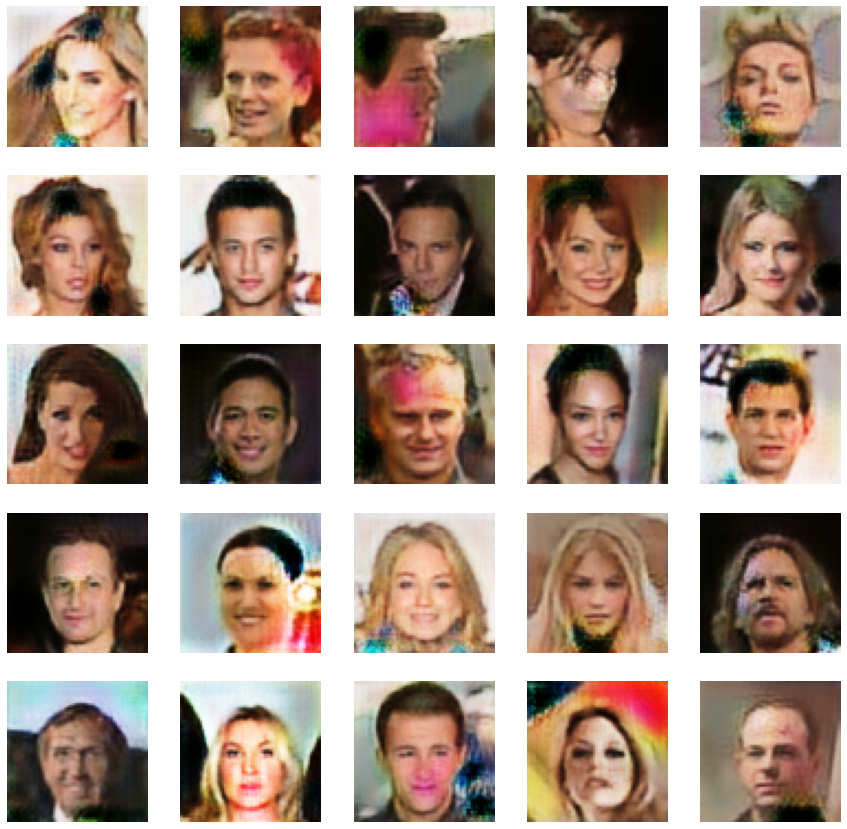

In [68]:
plt.figure(figsize=(15, 15))

image, label = next(iter(dataloader))

image, label = image.to(device), label.to(device).float()
target_domain = label.flip(dims=[0])

fake_image = gen(image, target_domain)
gen.eval()
for index in range(fake_image.shape[0]):
    if index >= 25:
        break
    image = fake_image[index].detach().cpu()
    plt.subplot(5, 5, index + 1)
    plot_img(image, t_invnormalize)
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

Target domain: Black_Hair


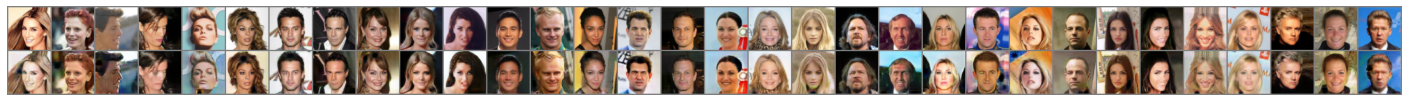

Target domain: Blond_Hair


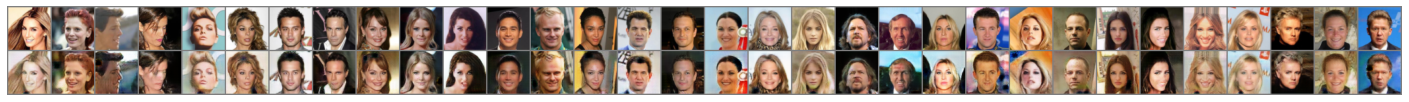

Target domain: Brown_Hair


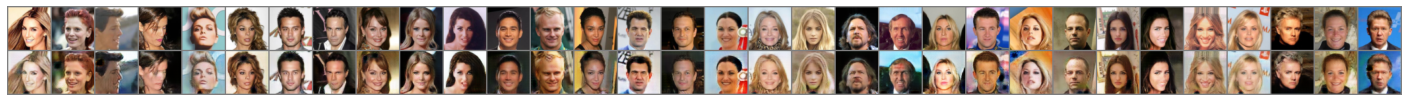

Target domain: Eyeglasses


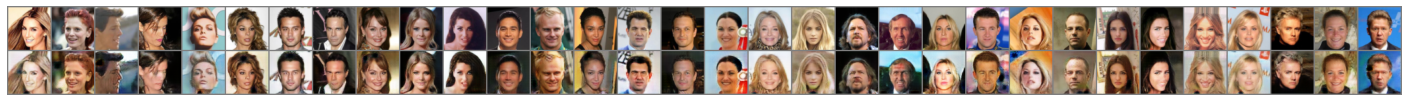

Target domain: Goatee


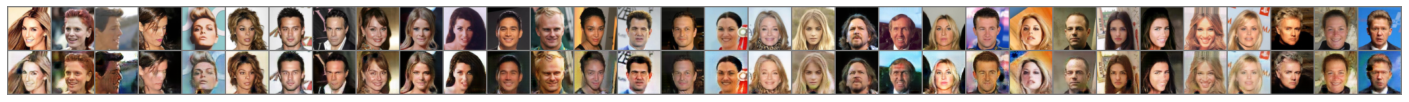

Target domain: Male


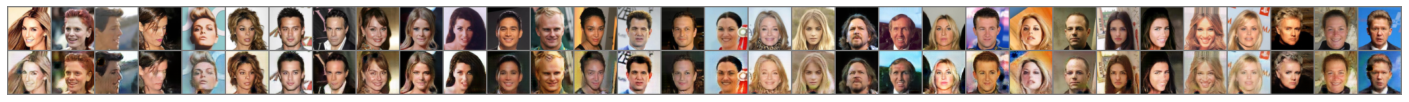

Target domain: Mustache


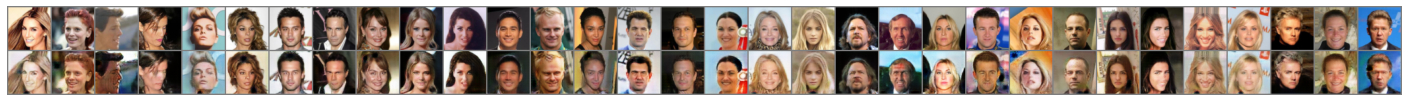

Target domain: Receding_Hairline


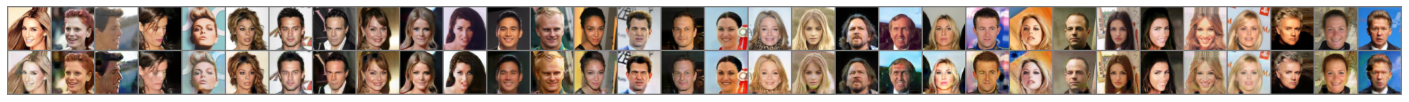

Target domain: Wearing_Hat


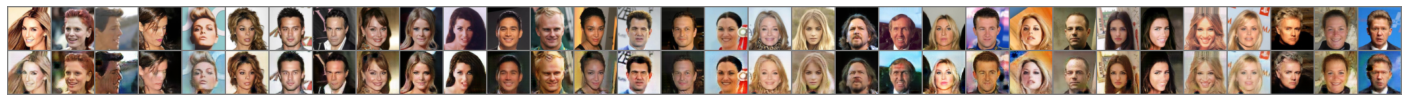

Target domain: Young


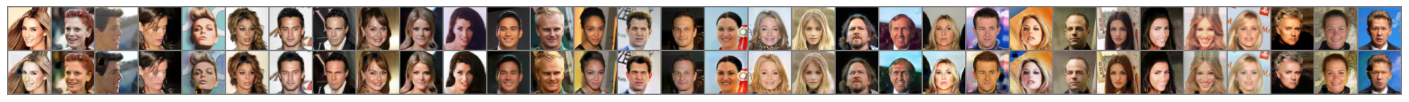

In [86]:
from torchvision.utils import make_grid

test_iters = 1
gen.eval()

iter_loader = iter(dataloader)

for i in trange(test_iters):
    x_real, y_real = next(iter_loader)
    y_real = y_real.float()

    x_real, y_real = x_real.to(device), y_real.to(device)

    for label_index in range(10):

        y_trg = y_real.clone().to(torch.float32)
        y_trg[:,label_index] = 1 - y_trg[:,label_index] # reverse

        print(f'Target domain: {attr_name[label_index]}')
        gen.eval()
        with torch.no_grad():
            x_fake = gen(x_real, y_trg)

        plt.figure(figsize=(25, 15))
        x_show = make_grid(torch.cat([x_real, x_fake], dim=0), nrow=x_fake.shape[0], normalize=False).detach().cpu()
        plot_img(x_show, t_invnormalize)
        plt.show()    


Во время обучения вы можете считать FID вашей модели, но для автопроверки мы решили использовать LPIPS — [Learned Perceptual Image Patch Similarity](https://arxiv.org/abs/1801.03924) как финальную метрику качества. 

Точную цифру для получения баллов за задание мы сообщим позже

In [70]:
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git -q

In [73]:
import os
os.environ['TORCH_HOME'] = './.cache/torch/hub'

In [87]:
# !pip install git+https://github.com/S-aiueo32/lpips-pytorch.git -q

from lpips_pytorch import LPIPS
lpips = LPIPS().to(device)

def evaluate_model(dataloader, generator):
    values = []
    for x_real, label in tqdm(dataloader):
        x_real, label = x_real.to(device), label.to(device).float()
        target_domain = label.flip(dims=[0])

        with torch.no_grad():
            x_fake = generator(x_real, target_domain)

        values.append(lpips(x_fake, x_real).squeeze().item())
    return np.mean(values)
    
evaluate_model(dataloader, gen)

  0%|          | 0/6331 [00:00<?, ?it/s]

1.9048487576163977

In [88]:
1.9048487576163977 / dataloader.batch_size

0.05952652367551243

### Задача 2 (5/10 баллов). Обучите low-res StarGanV2 на ограниченном подмножестве аттрибутов

В рамках второго задания предлагается реализовать и обучить [StarGAN v2](https://arxiv.org/abs/1912.01865)

<img src='https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/images/stargan_v2.png' width=600>

Вы можете добавлять любые дополнительные  параметры на свое усмотрение.


In [ ]:
class Generator(nn.Module):
    def __init__(self, style_dim: int = 128, hidden_dim: int = 32, depth: int = 4):
        super().__init__()
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

    def forward(self, x, s=None, y=None):
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim: int = 32, depth: int = 4):
        super().__init__()
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

    def forward(self, x: Tensor, y: Tensor):
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

In [ ]:
class StyleEncoder(nn.Module):
    def __init__(self, style_dim: int = 64, hidden_dim: int = 32, depth: int = 4):
        super().__init__()
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

    def forward(self, x: Tensor, y: Tensor):
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

In [ ]:
class MappingNetwork(nn.Module):
    def __init__(self, latent_dim: int = 16, style_dim: int = 64):
        super().__init__()
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

    def forward(self, z: Tensor, y: Tensor):
        ### BEGIN SOLUTION
        pass
        ### END SOLUTION

In [ ]:
### BEGIN SOLUTION

style_enc = StyleEncoder().to(device)
mapping = MappingNetwork().to(device)
gen = Generator().to(device)
disc = Discriminator().to(device)

g_optim = None # YOUR CODE
d_optim = None # YOUR CODE
s_optim = None # YOUR CODE
m_optim = None # YOUR CODE

### END SOLUTION

In [ ]:
def train_models(ckpt_file_path):
    ### BEGIN SOLUTION
    checkpoint = torch.load(ckpt_file_path, map_location=torch.device('cpu'))
    generator = Generator()
    generator.load_state_dict(checkpoint['generator'])
    style_encoder = StyleEncoder()
    style_encoder.load_state_dict(checkpoint['style_encoder'])
    ### END SOLUTION
    return generator, style_encoder

In [ ]:
def evaluate_model_by_reference(dataloader, generator, style_encoder, latent_dim):
    values = []
    for x_real, label in tqdm(dataloader):
        x_real, label = x_real.to(device), label.to(device).float()
        x_ref = x_real.flip(dims=[0])
        target_domain = label.flip(dims=[0])

        with torch.no_grad():
            s_trg = style_encoder(x_ref, target_domain)
            x_fake = generator(x_real, s_trg)

        values.append(lpips(x_fake, x_real).squeeze().item())
    return np.mean(values)
    
evaluate_model(dataloader, gen)

### Задача 3 (2/10 балла). Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **1+ балл**
1. Посмотрите получается ли у вас интерполяция в латентном пространстве
2. Покажите на каких доменах ваша модель работает хорошо, на каких не очень.
3. Попробуйте взять внешнюю картинку (не из селебы) и повторить результат.
4. Покажите самый смешной результат мультидоменной перекраски который у вас получался

* Текстовое ревью решения и предложения возможных улучшений - **1+ балл**
1. Опишите как вы решали задачу, какие методы описанные в статье вы использовали. Какие методы из других статей вы пробовали применять, что дало наибольший прирост в качестве?
2. Что бы вы предложили использовать еще, какие возможные улучшения здесь бы еще помогли получить бОльшее качество?


За хороший текст/результаты в этой задаче и за хорошее качество обученных моделей мы можем дать дополнительные баллы которые можно будет прибавить к другим домашкам :)

Эта задача выполняется отдельно и загружается в виде PDF в Anytask

### Отчет

В ходе выполнения работы мной был обучен StarGAN-v1. Для этого я реализовала архитектуру, описанную в оригинальной статье, а также алгоритм обучения.

1) Я использовала WGAN с GradientPenalty как adversarial составляющую лосса для обучения GANa. Помимо этого, я использовала ресблоки с Instance нормализацией, маленькие значения beta_1 для Adam для обоих сетей, дополнительные составляющие лосса (лосс на классификацию измененных атрибутов, ошибку реконструкции)

2) Из других методов я бы попробовала применить спектральную нормализацию для дискриминатора, чтобы обеспечить единичную норму его градиентов. Также можно было бы попробовать по-другому вычислять ошибку реконструкции (MSE или как-нибудь еще) 



### Анализ латентного пространства

In [24]:
gen.load_state_dict(torch.load('G_adam.ckpt'))

<All keys matched successfully>

#### Интерполяция

In [65]:
def get_interpolation_grid(x0, label0, x1, label1):
    alpha = torch.arange(start=0, step=0.1, end=1).view(10, 1, 1, 1)
    xs = x0[None, ...] * alpha + x1[None, ...] * (1 - alpha)
    labels = torch.stack([label0] * 5 + [label1] * 5, dim=0)
    x_fake = gen(xs, labels)
    
    plt.figure(figsize=(25, 15))
    x_show = make_grid(x_fake, nrow=x_fake.shape[0], normalize=False).detach().cpu()
    plot_img(x_show, t_invnormalize)
    plt.show()    

In [67]:
import random

In [70]:
def draw_interpolation_for_random_pair(dataset):
    idx0, idx1 = random.randint(a=0, b=len(dataset)), random.randint(a=0, b=len(dataset))
    x0, label0 = dataset[idx0]
    x1, label1 = dataset[idx1]
    get_interpolation_grid(x0, label0, x1, label1)

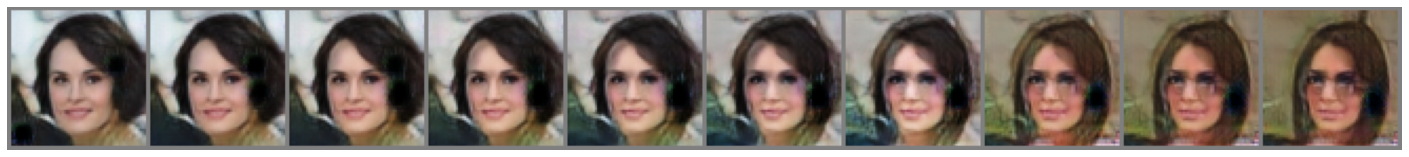

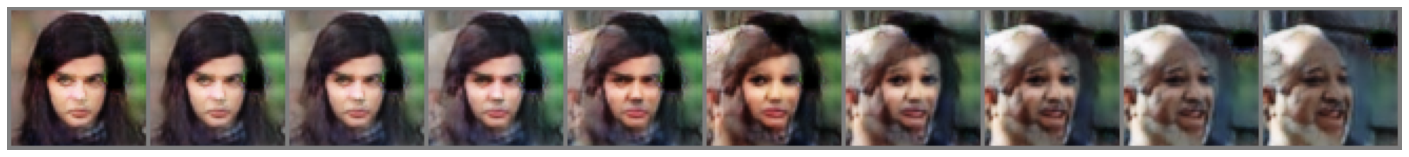

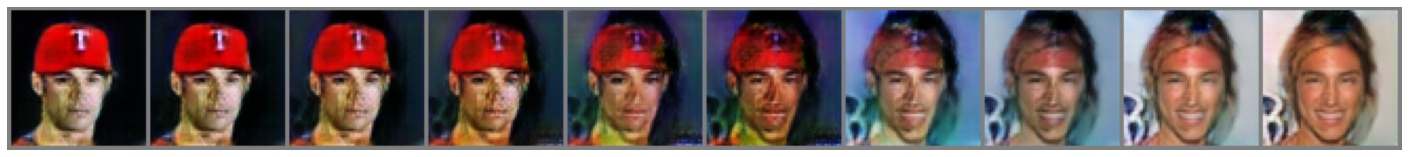

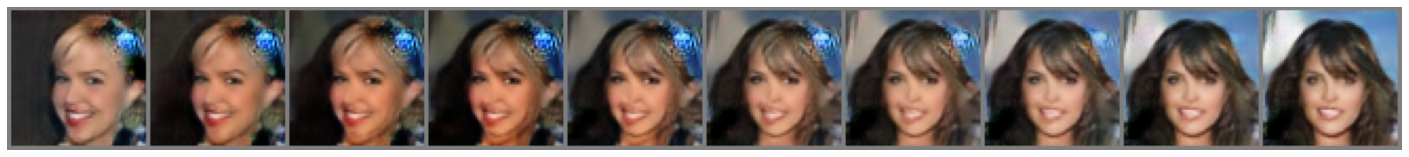

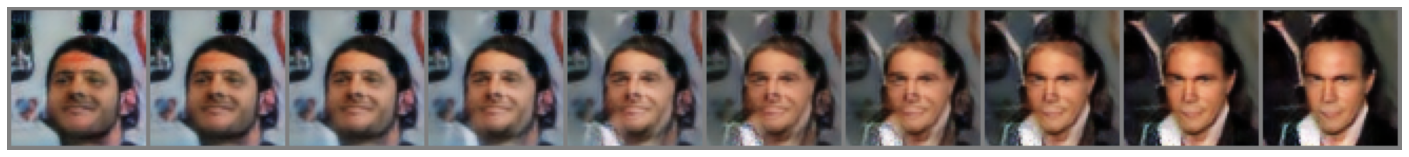

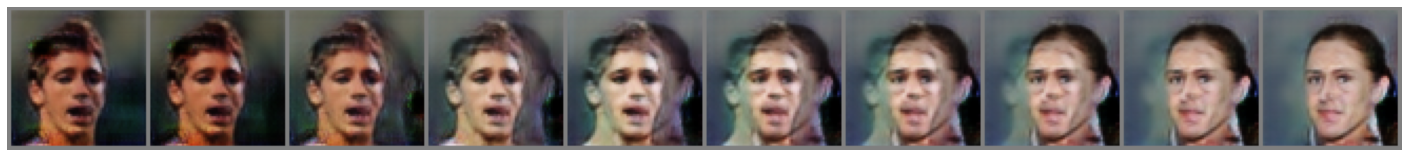

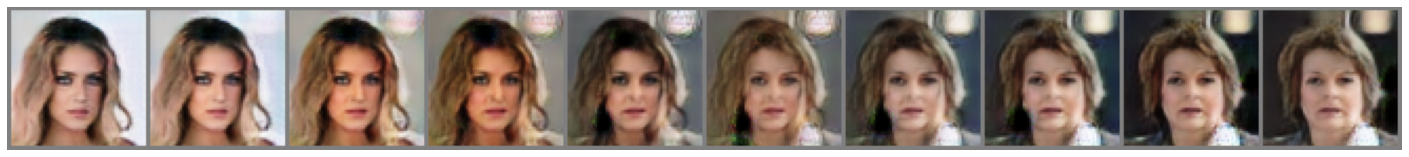

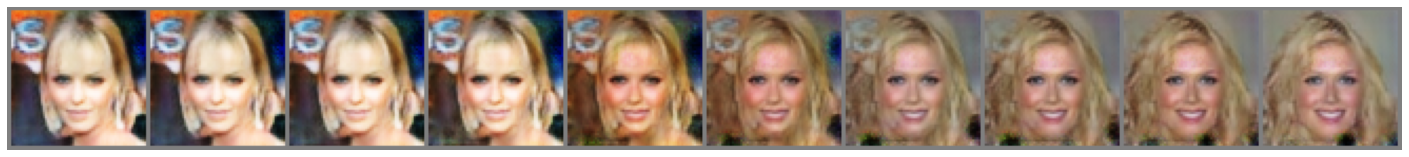

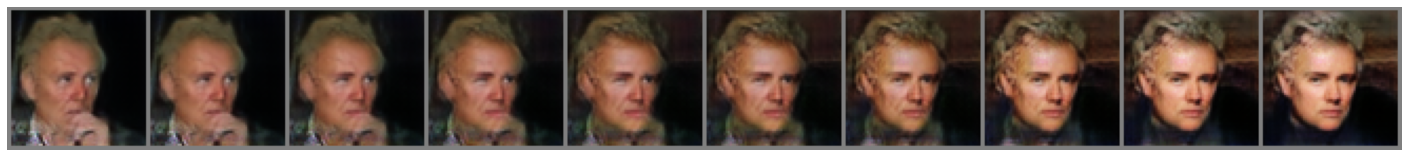

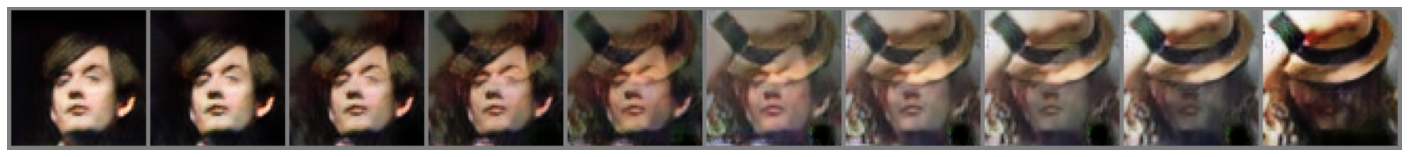

In [77]:
gen = gen.to('cpu')
for _ in range(10):
    draw_interpolation_for_random_pair(dataloader.dataset)

Как мы видим, интеполяция в латентон пространстве работает в 2х вариантах

1) [редко] реально похоже на интерполяцию (8, 9 примеры)

2) [часто] рисование одной картинки поверх другой и постепенная таким образом замена первой картинки на вторую (2, 3, 6 примеры)

В любом случае кажется, что линейная интерполяция работает достаточно неплохо. Интересно еще, что лицо почти везде интерполируется (положение лица на изображении не меняется, лицо постепенно переходит из одного в другое), а вот фон и какие-то атрибуты могут меняться кардинально.

#### Самое смешной результат перекраски

Вообще, это не совсем то что попросили, но пример #2 выше довольно смешной -- постепенный переход белой молодой чем-то огорченной девушки к довольному старому черному мужчине. 10ый переход тоже смешной -- похожий на недовольного Сашу Гудкова человек перешел в какое-то волосяное существо в шляпе. BrownHair